### Importing Libraries

In [1]:
import gc #garbage collector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from helper import utility
import importlib
importlib.reload(utility)


<module 'helper.utility' from 'c:\\Users\\adeli\\ML\\CE4041_ML-1\\helper\\utility.py'>

### Importing Zillow Datasets

In [2]:
# Raw data set provided
prop_2016 = utility.load_data('data/properties_2016.csv')
prop_2017 = utility.load_data('data/properties_2017.csv')
train_2016 = utility.load_data('data/train_2016_v2.csv' , ['transactiondate'])
train_2017 = utility.load_data('data/train_2017.csv', ['transactiondate'])

In [3]:
# Combining the prop dataset with its corresponding train datasets on their parcelid
# left join is used so that all properties without logerror will be ignored
training_2016 = utility.merge_data(train_2016, prop_2016, 'parcelid')
training_2017 = utility.merge_data(train_2017, prop_2017, 'parcelid')



# Data across the 2 years are combined into one data frame for processing at later stages
training_all = pd.concat([training_2016, training_2017] , ignore_index=True)
properties_all = pd.concat([prop_2016, prop_2017], ignore_index=True) 


training_all
#properties_all.shape


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.168400,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.004000,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.021800,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.005000,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13


In [4]:
# Check and Drop any duplicates in the training dataset
# Duplicates are those which have the same parcelid and transactiondate

training_all.shape
utility.check_duplicates(training_all)
training_all = utility.drop_dups(training_all)

There are 0 duplicate IDs for 167888 total entries


In [5]:
# We can see that there are no duplicates in the dataset so far
training_all.shape

(167888, 60)

### Looking at the Target Variable - logerror

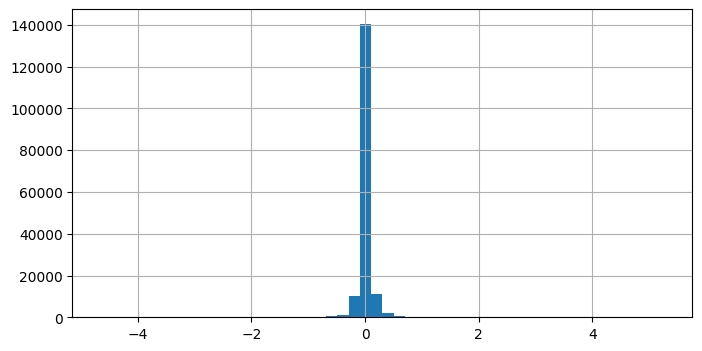

In [6]:
target_y = training_all['logerror']


target_y.hist(bins=50, figsize=(8,4))
plt.show()

In [7]:
target_y.describe()

count    167888.000000
mean          0.013906
std           0.165706
min          -4.655420
25%          -0.025300
50%           0.006000
75%           0.039200
max           5.262999
Name: logerror, dtype: float64

In [8]:
# Drop outliers that are more than 2.5 std away from mean
upper_threshold = target_y.mean() + (2.5*target_y.std())
lower_threshold = target_y.mean() - (2.5*target_y.std())


# Remove data that have their target y value as outliers
training_all = training_all[training_all['logerror'] < upper_threshold]
training_all = training_all[training_all['logerror'] > lower_threshold]
training_all.shape



(164566, 60)

### Data Preprocessing & Feature Engineering

In [9]:
# Adding Feature to the dataset
# Add Day, Month, Year and which quarter the transaction was done
training_all = utility.add_dmy_feature(training_all)
training_all

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,quarter,day,transaction_year,transaction_month
0,11016594,0.027600,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13,1,1,2016,1
1,14366692,-0.168400,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,2015.0,239071.0,10153.02,NaN,NaN,NaN,1,1,2016,1
2,12098116,-0.004000,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13,1,1,2016,1
3,12643413,0.021800,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13,1,2,2016,1
4,14432541,-0.005000,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13,1,2,2016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167883,10833991,-0.002245,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13,3,20,2017,9
167884,11000655,0.020615,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,3,20,2017,9
167885,17239384,0.013209,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13,3,21,2017,9
167886,12773139,0.037129,1.0,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,3,21,2017,9


In [10]:
utility.print_percent_missing(training_all)

buildingclasstypeid : 99.99%

finishedsquarefeet13 : 99.96%

basementsqft : 99.95%

storytypeid : 99.95%

yardbuildingsqft26 : 99.90%

fireplaceflag : 99.76%

architecturalstyletypeid : 99.72%

typeconstructiontypeid : 99.69%

finishedsquarefeet6 : 99.54%

decktypeid : 99.24%

pooltypeid10 : 99.03%

poolsizesum : 98.89%

pooltypeid2 : 98.64%

hashottuborspa : 97.67%

taxdelinquencyflag : 97.28%

taxdelinquencyyear : 97.28%

yardbuildingsqft17 : 96.98%

finishedsquarefeet15 : 96.21%

finishedfloor1squarefeet : 92.26%

finishedsquarefeet50 : 92.26%

fireplacecnt : 89.26%

threequarterbathnbr : 86.72%

pooltypeid7 : 81.01%

poolcnt : 79.64%

numberofstories : 77.19%

airconditioningtypeid : 67.76%

garagecarcnt : 66.75%

garagetotalsqft : 66.75%

regionidneighborhood : 60.21%

heatingorsystemtypeid : 37.04%

buildingqualitytypeid : 36.28%

propertyzoningdesc : 35.37%

unitcnt : 35.20%

lotsizesquarefeet : 11.05%

finishedsquarefeet12 : 4.79%

regionidcity : 1.98%

calculatedbathnbr : 1.02

In [11]:
# Drop all columns that have missing threashold greater than 95%
MISSING_THRESHOLD = 0.97
col_to_drop = utility.get_col_to_drop_missing(training_all, 0.95)
col_to_drop += utility.get_col_to_drop_non_unique(training_all)

# Other columns to exlude to prepare for training dataset
exclude_list = ["parcelid" , "logerror" , 'propertyzoningdesc']

remaining_col = []
for col in training_all.columns:
    if col not in col_to_drop and col not in exclude_list:
        remaining_col.append(col)
        print(col)



18 has been flagged out

9 has been flagged out

airconditioningtypeid
bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
finishedfloor1squarefeet
calculatedfinishedsquarefeet
finishedsquarefeet12
finishedsquarefeet50
fips
fireplacecnt
fullbathcnt
garagecarcnt
garagetotalsqft
heatingorsystemtypeid
latitude
longitude
lotsizesquarefeet
propertycountylandusecode
propertylandusetypeid
rawcensustractandblock
regionidcity
regionidcounty
regionidneighborhood
regionidzip
roomcnt
threequarterbathnbr
unitcnt
yearbuilt
numberofstories
structuretaxvaluedollarcnt
taxvaluedollarcnt
assessmentyear
landtaxvaluedollarcnt
taxamount
censustractandblock
quarter
day
transaction_year
transaction_month


In [12]:
# Dealing with Categorical Values
# Convert categorical values to 'category' type for some columns

categorylist = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 
                'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid' , 
                'propertylandusetypeid', 'regionidcity', 'regionidcounty', 
                'regionidneighborhood', 'storytypeid', 'typeconstructiontypeid']

for col in training_all.columns:
    if col in categorylist: 
        utility.float_to_categorical(training_all, col)


In [16]:
# Convert float64 values to float32 values 
for col in training_all.columns: 
    if training_all[col].dtype.name == 'float64': 
        training_all[col] = training_all[col].astype('float32')

In [17]:
training_all.dtypes

parcelid                       int64
logerror                     float32
airconditioningtypeid       category
architecturalstyletypeid    category
basementsqft                 float32
                              ...   
censustractandblock          float32
quarter                        int32
day                            int32
transaction_year               int32
transaction_month              int32
Length: 63, dtype: object

### Training models